# Fork Join Parallelism

Fork Join is a model of computation used to express parallel programs

It used used in OpenMP as well as in unix style pthreads

## Operations

The fork join model has two basic primitives

### Fork
Fork specifies a set of work that is "forked-off" and can be executed  in parallel with the rest of the function

### Join
join specifies waiting until the forked off thread completes


## Examples
All python style examples are just pseudo code and are not meant to run
### Sorting
```python
# taken from wikipedia
def mergesort(A, lo, hi):
    if lo < hi: # ensure we have input
        mid = ⌊lo + (hi - lo) / 2⌋
        fork mergesort(A, lo, mid) # sort the first half concurrently 
        mergesort(A, mid, hi) # have the main thread sort the second half
        join # wail till both are done
        merge(A, lo, mid, hi)
````
### Fibonacci

```python
def fib(n):
    if n < 2: # handle the small case
        return n
    x = fork fib(n-1) # fork of the larger half
    y = fib(n-2) # compute the smaller half
    join # wait till both are done
    return x + y
``` 


## Fib(5)

Lets walk through an example of what fib(5) actually does in a divide and conquer approach

FileNotFoundError: [Errno 2] No such file or directory: '../images/fork_join_lec/divide_and_conquer0.png'

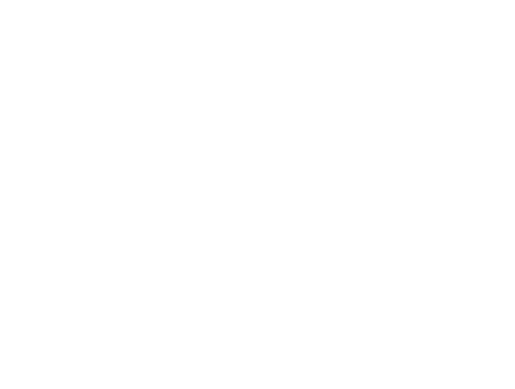

In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation
import matplotlib.image as mgimg
fig = plt.figure()
plt.axis('off')
ani = matplotlib.animation.ArtistAnimation(fig, [[plt.imshow(mgimg.imread("../images/fork_join_lec/"+fname))]
              for fname in ["divide_and_conquer"+str(i)+".png" for i in range(10)]])
from IPython.display import HTML
HTML(ani.to_jshtml())

Now we wish to look at it in a fork join style, let's start by transforming the code to remove the recursion

You can basically think of this as mirroring the computation so we show the joins as new steps instead of just going back up the tree 
![fork_join](images/fork_join_lec/fork_join.png "fork_join")


## Work

The work is the total number of operations of a computation.  This is the standard measure you probably think about when you think about analyzing an algorithm

## Span
Span (also known as depth) is the longest path through the dag of computation.  Or the longest chain of dependencies.  This measured the time to compute on an infinite number processors if forking and joining has no cost


## Parallel For Loop

A common operation that you want to do is run a loop with all of the iterations running in parallel.

```python
def dot_product(A, B, C):
    length = len(A)
    parallel_for (0, length, lambda i : C[i] = A[i] * B[i])
```

```python
def parallel_for1(start, end, func):
    for i in range(start, end):
        fork func(i)
    join
```

Assuming that func is O(1) what is the work of parallel_for1?

What is the span? 

## Reducing the Span 

```python
def parallel_for2(start, end, func):
    if end - start < Threshold:
        for i in range(start, end):
            func(i)
    middle = start + (end - start) / 2
    fork parallel_for2(start, middle, func)
    parallel_for2(middle, end, func)
    join
```

Assuming that func is O(1) what is the work of parallel_for1?

What is the span? 

## Reducers

Let's say we want to do the simple operations of of summing up a vector
```python
def bad_sum(A):
    total = 0
    # This code has a race condition on total
    # since multiple threads read and write the same value
    parallel_for (0, len(A), lambda i : total += total[i])
    return total
```

A reducer (which corresponds to the algebraic object of a monoid) is an object designed to allow multiple threads to all contribute to some value through associative operations.

A reducer is defined by two functions, identity and combine.

The identity specifies the original or default value for the object, and the combine function specifies how to combine two different values.

For example a summation reducer can be defined as follows

```python
def identity():
    return 0
def combine(a, b):
    return a+b

total = Reducer(identity, combine)
```

What would the identity and combine functions be for a min reducer?


## Implementing a basic reducer
```python
class Reducer()
    def __init(self, identity, combine):
        # store the identity and combine
        self.identity = identity
        self.combine = combine
        # give each thread its own value to manipulate
        self.thread_local = [self.identity() for i in num_threads()]

    def update(new_value):
        # only update the thread local copy
        self.thread_local[thread_id()] = self.combine(self.thread_local[thread_id()], new_value)

    def value()
        # combine all thread_local values
        val = self.identity()
        for thread_value in self.thread_local:
            val = combine(val, thread_value)
        return val
```

Sum function using a reducer
```python
def good_sum(A):
    total = Reducer(identity, combine)
    parallel_for (0, len(A), lamda i : total.update(total[i]))
    return total.value()
```

# Cilk
For more information see [opencilk](https://www.opencilk.org/)
To download see [github](https://github.com/OpenCilk/opencilk-project)

Cilk is a task parallel platform for shared memory programming using fork=join parallelism for c and c++.

Cilk is designed to allow the user to express logical parallelism without needing to think about any of the implementation details.

Cilk has 2 major keywords
- cilk_spawn which corresponds to a fork
- cilk_scope which defines when and what to join


## Examples of code using Cilk

```c++
int fib(int n) {
  if (n < 2)
    return n;                   // base case
  int x, y;
  cilk_scope {                  // begin lexical scope of parallel region
    x = cilk_spawn fib(n-1);  // don't wait for function to return
    y = fib(n-2);             // may run in parallel with spawned function
  }                             // wait for spawned function if needed
  return x + y;
}
```

For ease cilk also provides a parallel for loop with `cilk_for`

```c++
void dot_product(int* A, int* B, int* C, int n){
  cilk_for(in i = 0; i < n; i++) {
    C[i] = A[i]*B[i];
  }
}
```

### Reducers using Cilk

```c++
void identity(void *view) { *(int *)view = 0.0; }
void combine(void *left, void *right) { *(int *)left += *(int *)right; }

int sum(int* A, int n) {
  int cilk_reducer(identity, combine) total;
  cilk_for(int i = 0; i < n; i++) {
    total += A[i];
  }
}
```

you can also use the build in reducers by declaring them like

`cilk::opadd_reducer<int> reducer = 0.0;`

One benefit of cilk code is that it has serial semantics (serial equivalence), that means if you just delete every cilk keyword (or use `#define` to remove them) the code should be a correct standard serial c++ program with the same behavior 



# Try it yourself 
Go to speedcode at [http://preview.speedcode.org/](http://preview.speedcode.org/)

First try Integral.  Once you are finished that continue with Matrix Multiplication.

If you finish that feel free to try any of the others, my recommendation is Triangle counting.

```c++
double integral(const Func& f, size_t n, double low, double high) {
  double ans = 0.0;
  for (int i=0; i<n; i++) {
    double x = low + (high-low)*i/n;
    double dx = (high-low)/n;
    ans += f(x) * dx;
  }
  return ans;
}

void mat_mul(float *__restrict__ C, const float *__restrict__ A,
                    const float *__restrict__ B, int64_t m, int64_t n,
                    int64_t l) {
  for (int64_t i = 0; i < m; ++i) {
    for (int64_t j = 0; j < n; ++j) {
      C[i * n + j] = 0;
      for (int64_t k = 0; k < l; ++k) {
        C[i * n + j] += A[i * l + k] * B[k * n + j];
      }
    }
  }
}
```